# Summary

Welcome to the Binary Classification with Bank Churn Dataset competition! In this challenge, our goal is to predict customer churn based on a comprehensive set of information. The dataset comprises 13 columns, each offering valuable insights into customer behavior and characteristics:

    01. Customer ID: A unique identifier for each customer.
    02. Surname: The customer's last name or surname.
    03. Credit Score: A numerical representation of the customer's credit score.
    04. Geography: The country where the customer resides, with options including France, Spain, or Germany.
    05. Gender: The customer's gender, categorized as Male or Female.
    06. Age: The customer's age.
    07. Tenure: The number of years the customer has been associated with the bank.  
    08. Balance: The current account balance of the customer.
    09. NumOfProducts: The count of bank products the customer uses, such as savings accounts or credit cards.
    10. HasCrCard: A binary indicator of whether the customer possesses a credit card (1 = yes, 0 = no).
    11. IsActiveMember: A binary indicator of the customer's active membership status (1 = yes, 0 = no).
    12. EstimatedSalary: The estimated salary of the customer.
    13. Exited: The target variable indicating whether the customer has churned (1 = yes, 0 = no).
    
Throughout the competition, our performance will be evaluated using the Area Under the ROC Curve (AUC-ROC) metric, a widely-used measure for assessing binary classification models. For more details about the original dataset, please refer to the Kaggle dataset page: [Bank Customer Churn Prediction](https://www.kaggle.com/datasets/shantanudhakadd/bank-customer-churn-prediction). Let's embark on this predictive analytics journey and strive for accurate churn predictions!

# Imports

In [1]:
# Libraries for data wrangling
import pandas as pd
import numpy as np 
# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
#Library to see the progress
from tqdm import tqdm


# Libraries with functions used in modelling
from sklearn.base import clone
from sklearn.inspection import permutation_importance
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from category_encoders import MEstimateEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

# Libraries with the models
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


# Library to ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(0, r'C:\Users\Vitor\Documents\Repositórios\Kaggle\utils')
# Custom functions to analyze data
from eda_functions import summary_statistics, heatmap, feature_distance
from model_functions import adversarial_validation, cross_val_score


In [3]:
sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

In [4]:
seed = 10

# Loading data

In [58]:
df_train = pd.read_csv("data/train.csv", index_col='id')
df_test = pd.read_csv("data/test.csv", index_col='id')

In [59]:
numerical_features = list(df_test._get_numeric_data())
categorical_features = list(df_test.drop(numerical_features, axis = 1))

# Encoding of the data

In [60]:
# 'categorical_columns' should contain the names of the categorical columns you want to encode
onehot_columns = ['Geography', 'Gender']  # replace with your actual column names

# Extract the categorical columns from the DataFrame
df_onehot = df_train[onehot_columns]

# Create an instance of OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Fit and transform the categorical columns
df_train_encoded = pd.DataFrame(encoder.fit_transform(df_onehot), columns=encoder.get_feature_names_out(onehot_columns))

# Concatenate the one-hot encoded columns with the original DataFrame
df_train = pd.concat([df_train, df_train_encoded], axis=1)

# Drop the original categorical columns if needed
df_train = df_train.drop(onehot_columns, axis=1)

In [61]:
# 'categorical_columns' should contain the names of the categorical columns you want to encode
onehot_columns = ['Geography', 'Gender']  # replace with your actual column names

# Extract the categorical columns from the DataFrame
df_onehot_test = df_test[onehot_columns]

# Create an instance of OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Fit and transform the categorical columns
df_test_encoded = pd.DataFrame(encoder.fit_transform(df_onehot_test), columns=encoder.get_feature_names_out(onehot_columns))

# Drop the original categorical columns if needed
df_test = pd.merge(left=df_test.reset_index().reset_index(), right=df_test_encoded.reset_index(), how='inner', on='index').drop(columns=['index'] + onehot_columns)

In [65]:
df_test = df_test.set_index('id')

In [9]:
X = df_train.copy()
y = X.pop('Exited')

splits = 5
skf = StratifiedKFold(n_splits = splits, random_state = seed, shuffle = True)
np.random.seed(seed)

# Model Cross Validation
Let's start by evaluating the performance of our model first. We will use M-Estimate Encoder and Standard Scaler in our pipeline. We will also concatenate the original dataset only during the cross-validation process for robustness.

In [10]:
score_list, oof_list = pd.DataFrame(), pd.DataFrame()

models = [
    ('log', LogisticRegression(random_state = seed, max_iter = 1000000)),
    ('lda', LinearDiscriminantAnalysis()),
    ('gnb', GaussianNB()),
    ('bnb', BernoulliNB()),
    ('rf', RandomForestClassifier(random_state = seed)),
    ('et', ExtraTreesClassifier(random_state = seed)),
    ('xgb', XGBClassifier(random_state = seed)),
    ('lgb', LGBMClassifier(random_state = seed)),
    ('dart', LGBMClassifier(random_state = seed, boosting_type = 'dart')),
    ('cb', CatBoostClassifier(random_state = seed, verbose = 0)),
    ('gb', GradientBoostingClassifier(random_state = seed)),
    ('hgb', HistGradientBoostingClassifier(random_state = seed)),
]

for (label, model) in models:
    score_list[label], oof_list[label] = cross_val_score(dataset=df_train, 
                                                         estimator = make_pipeline(MEstimateEncoder(cols = ['Surname']), StandardScaler(), model),
                                                         cv = skf,
                                                         seed = seed,
                                                         label=label,
                                                         show_importance = False)

Val Score: 0.82296 ± 0.00179 | Train Score: 0.83654 ± 0.00044 | log
Val Score: 0.82279 ± 0.00175 | Train Score: 0.83677 ± 0.00044 | lda
Val Score: 0.81306 ± 0.00271 | Train Score: 0.82260 ± 0.00065 | gnb
Val Score: 0.82134 ± 0.00176 | Train Score: 0.82673 ± 0.00030 | bnb
Val Score: 0.88133 ± 0.00162 | Train Score: 1.00000 ± 0.00000 | rf
Val Score: 0.87901 ± 0.00195 | Train Score: 1.00000 ± 0.00000 | et
Val Score: 0.88336 ± 0.00169 | Train Score: 0.92709 ± 0.00080 | xgb
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1380
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] St

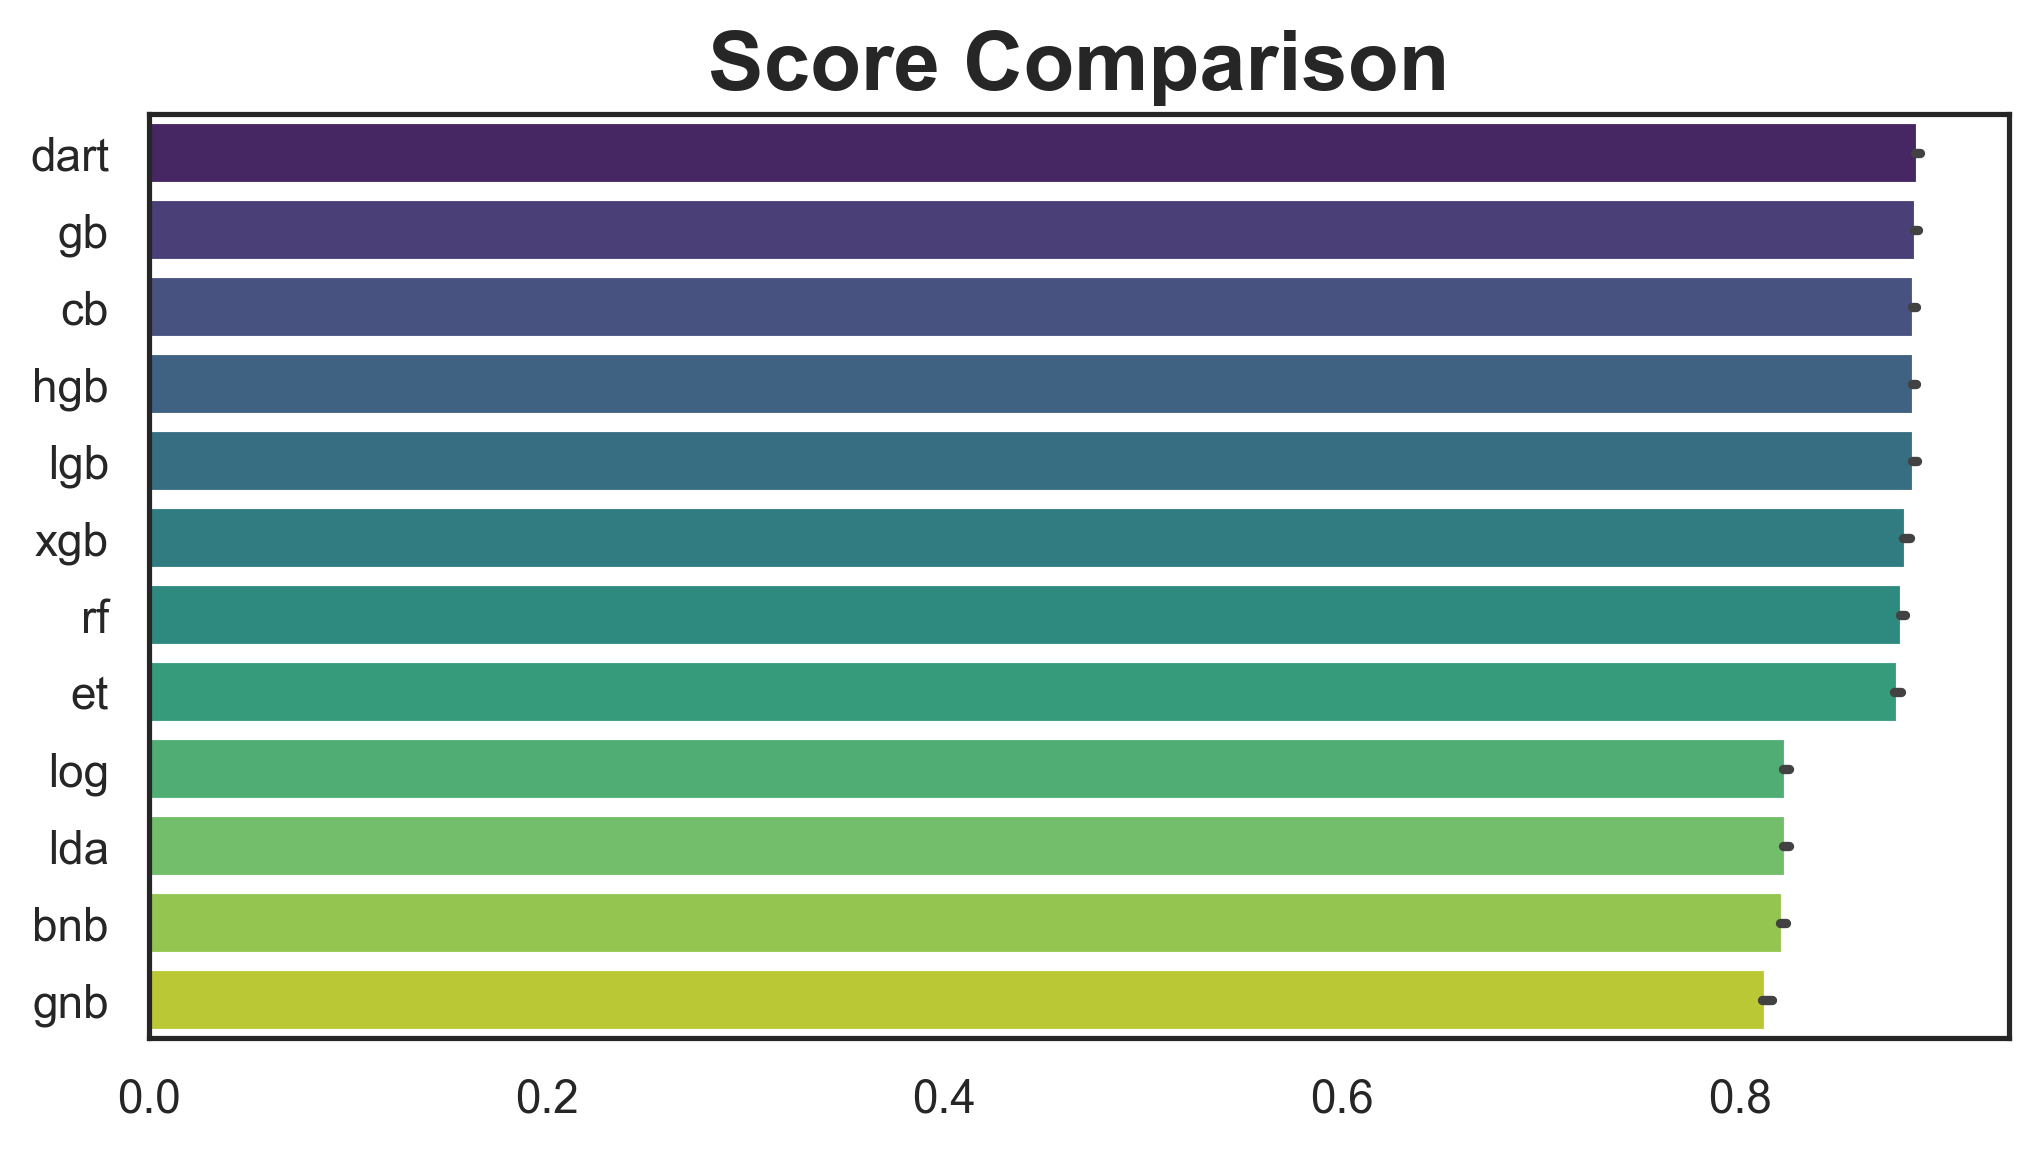

In [11]:
plt.figure(figsize = (8, 4), dpi = 300)
sns.barplot(data = score_list.reindex((-1 * score_list).mean().sort_values().index, axis = 1), palette = 'viridis', orient = 'h')
plt.title('Score Comparison', weight = 'bold', size = 20)
plt.show()


# Voting Ensemble
Now let's try to define the weight of each model and then build a voting ensemble. We will use Ridge Classifier to define the weight by fitting it on OOF prediction and the true label.

In [12]:
weights = RidgeClassifier(random_state = seed).fit(oof_list, df_train.Exited).coef_[0]
pd.DataFrame(weights, index = list(oof_list), columns = ['weight per model'])

,weight per model
log,-0.225130
lda,0.108490
gnb,-0.036474
bnb,0.080675
rf,0.139767
et,0.210997
xgb,0.229733
lgb,-0.269777
dart,0.654740
cb,0.819444


After defining the weight, we can start building a Voting Ensemble of our models.

[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1380
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1380
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 15
[LightGBM] [In

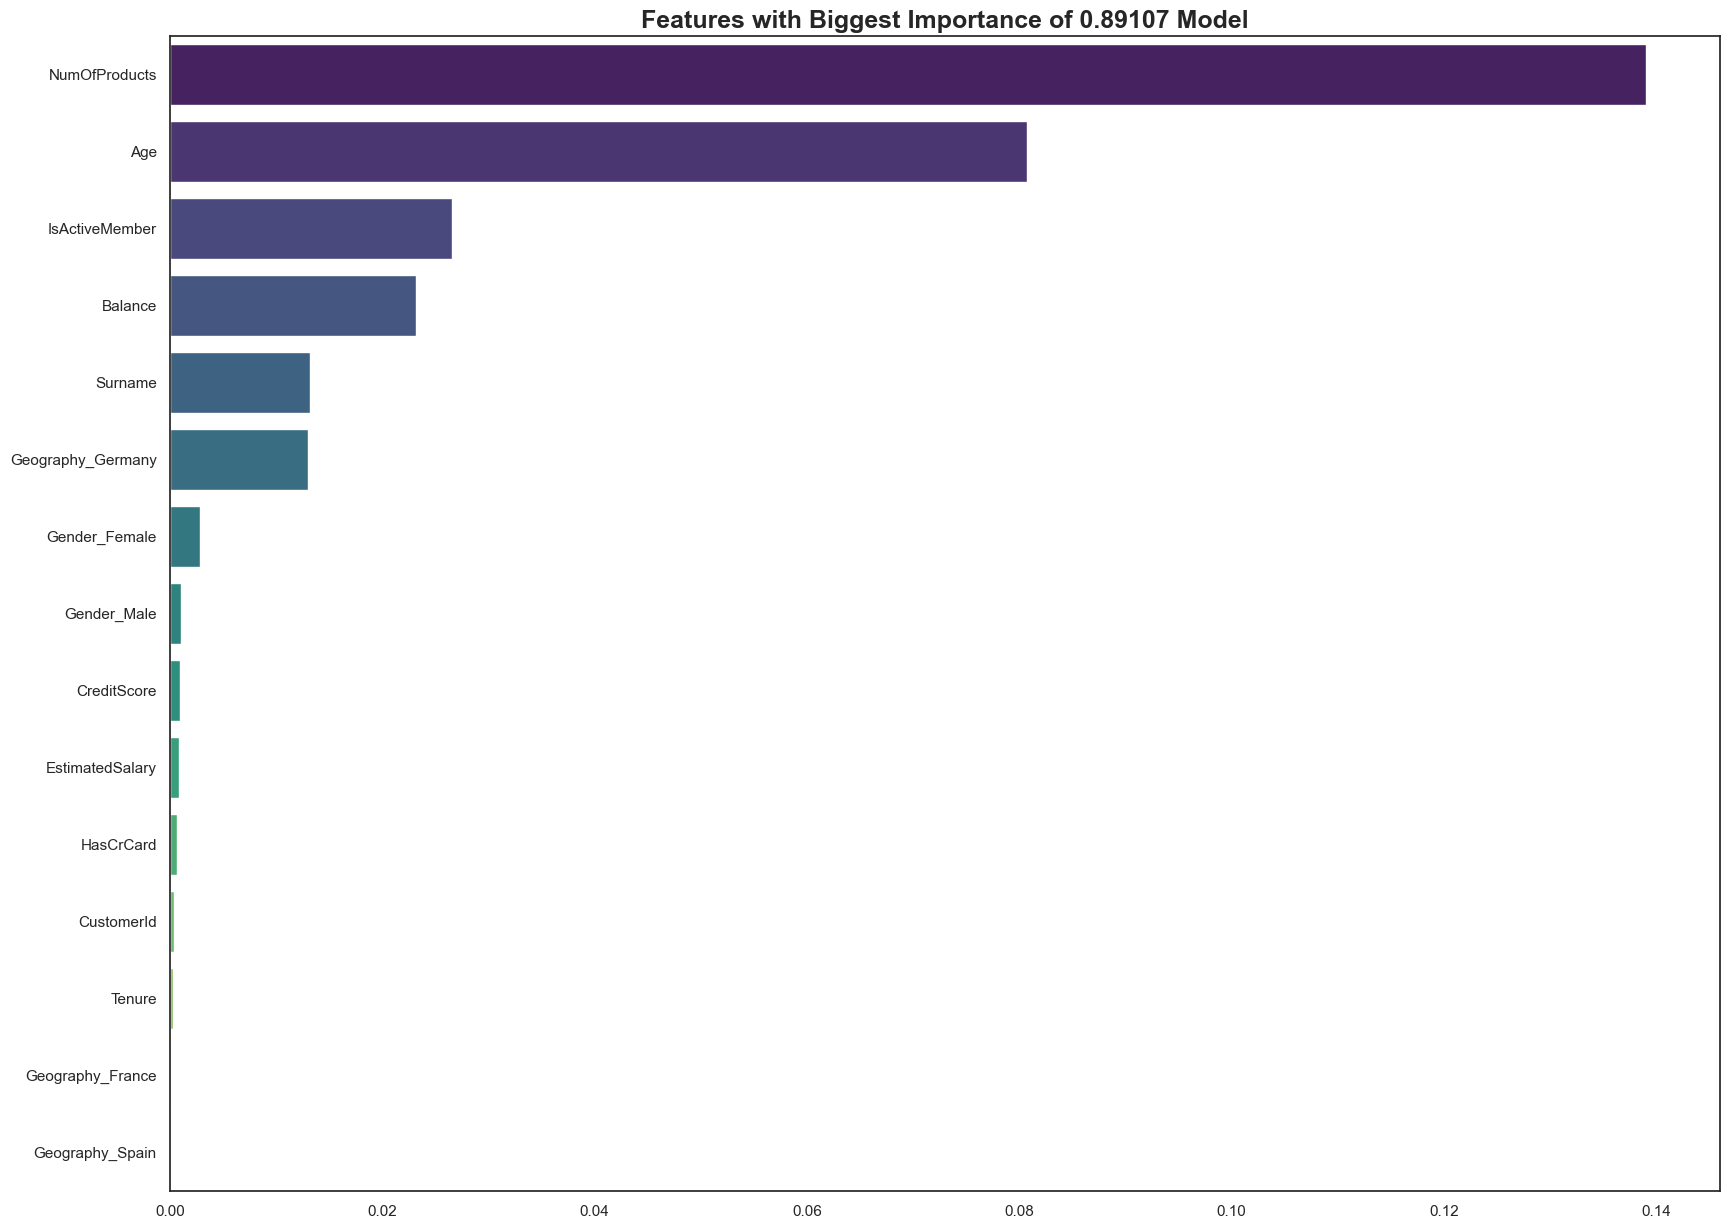

In [13]:
voter = VotingClassifier(models, weights = weights, voting = 'soft')

_ = cross_val_score(dataset=df_train,
                    estimator= make_pipeline(MEstimateEncoder(cols = ['Surname']), StandardScaler(), voter),
                    cv = skf,
                    seed=seed,
                    label="",
                    show_importance = True)

We can see an improvement in the CV score above!

# Prediction and Submission
Finally, let's train our chosen model on the whole train dataset and do prediction on the test dataset.

In [14]:
model = make_pipeline(
    MEstimateEncoder(cols = ['Surname']),
    StandardScaler(),
    voter
)

model.fit(X, y)

[LightGBM] [Info] Number of positive: 34921, number of negative: 130113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1382
[LightGBM] [Info] Number of data points in the train set: 165034, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211599 -> initscore=-1.315315
[LightGBM] [Info] Start training from score -1.315315
[LightGBM] [Info] Number of positive: 34921, number of negative: 130113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1382
[LightGBM] [Info] Number of data points in the train set: 165034, number of used features: 15
[LightGBM] [In

Pipeline(steps=[('mestimateencoder', MEstimateEncoder(cols=['Surname'])),
                ('standardscaler', StandardScaler()),
                ('votingclassifier',
                 VotingClassifier(estimators=[('log',
                                               LogisticRegression(max_iter=1000000,
                                                                  random_state=10)),
                                              ('lda',
                                               LinearDiscriminantAnalysis()),
                                              ('gnb', GaussianNB()),
                                              ('bnb', BernoulliNB()),
                                              ('rf',
                                               RandomForestClassifier(random_state=10)),
                                              ('et'...
                                                              random_state=10)),
                                              ('cb',
                                               <catboost.core.CatBoostClassifier object at 0x000001701F840390>),
                                              ('gb',
                                               GradientBoostingClassifier(random_state=10)),
                                              ('hgb',
                                               HistGradientBoostingClassifier(random_state=10))],
                                  voting='soft',
                                  weights=array([-0.22513033,  0.10849015, -0.0364739 ,  0.08067466,  0.1397669 ,
        0.21099685,  0.22973293, -0.26977688,  0.65473971,  0.81944445,
        0.20549075,  0.12671235])))])

In [66]:
submission = df_test.copy()
submission['Exited'] = model.predict_proba(submission)[:, 1]

submission.Exited.to_csv('data/submission_one_hot.csv')

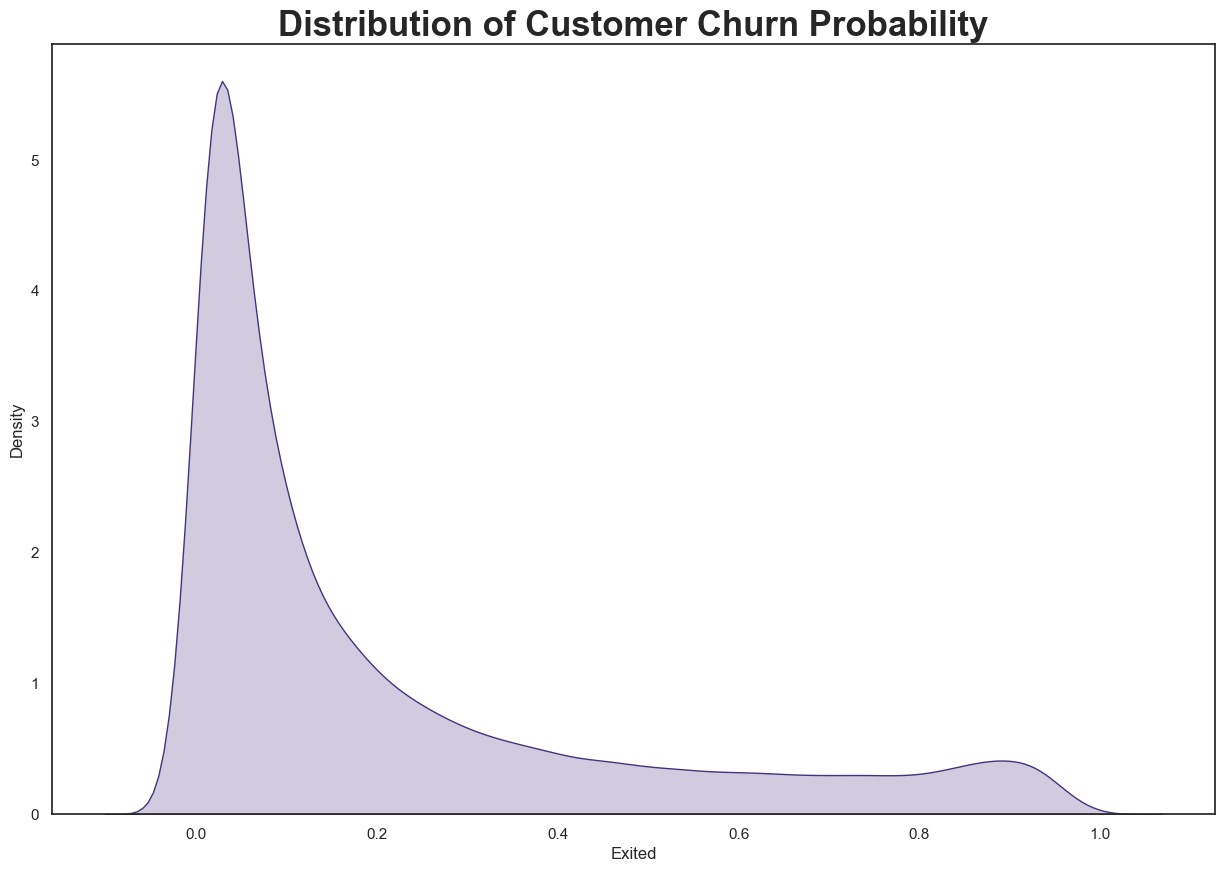

In [57]:
plt.figure(figsize = (15, 10))
sns.kdeplot(submission.Exited, fill = True)
plt.title("Distribution of Customer Churn Probability", weight = 'bold', size = 25)
plt.show()